## Introduction

AutoML was used to find an optimal model for our dataset.

## Description

Basically 2 AutoML libraries were used, H2o and TPOT whereas AutoKeras was not used since it performes DeepLearning and DL was our last resort. Both libraries couldn't use XGBoost as its implementation is buggy for windows and now it is no longer available on windows.
>- TPOT
>>- 2 experiments were run, first with 10 models and second with 50 models.
>>- Both experiments settled for ExtraTreesClassifier. 
>>- Unfortunately, both models performed moderately on Train data but poorly on Test data. One of the explanantion can be overfitting.
>>- For first experiment 'roc_auc' was selected as scoring criteria but for second experiment 'average_precision' (area under recall-precision graph) was used.
>>- TPOT didnt provide any option for class balance or class weights.

>- H2o
>>- One benefit H2o over TPOT was the availablity of the option of balance class.
>>- 'roc_auc' was used as scoring criteria.
>>- H2o settled for StackedEnsemble.
>>- Model worked moderately on Training data but poorly on Testing data


## Conclusions
>- Unfortunately both libraries didn't perform good on testing data. H2o gave slightly better results as compare to TPOT but no where acceptable.
>- Both libraries took too long to train, it is only fair since it trains multiple models but poor performance calls for multiple experiments with hypertuning and some more research. 

In [1]:
import pandas as pd
import numpy as np
from tpot import TPOTClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [9]:
# confusion matrix plot
def plot_cm(cm):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(cm, annot=True,cmap="OrRd",fmt='g')
    plt.title('confusion matrix')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.show()

In [10]:
# plots ROC curve
def ROC(y_test,probs):
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = f'AUC = {round(roc_auc,3)}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [11]:

def bins_edges(bin_size = 0.01,min_edge = 0.5,max_edge = 1):
    bin_size = bin_size; min_edge = min_edge; max_edge = max_edge
    N = (max_edge-min_edge)/bin_size; Nplus1 = round(N) + 1
    bins = np.linspace(min_edge, max_edge, Nplus1)
    return bins

def bars(df,cls = 0, bins = bins_edges()):
    groups = df.groupby(pd.cut(fpr_df.probs, bins = bins))
    FPR_list = list()
    for grp in groups:
        grp = pd.DataFrame(grp[1])
        if grp.empty:
            FPR_list.append(0)  
        else:
            FPR = grp[grp['class'] == cls].shape[0]/grp.shape[0]
            FPR_list.append(FPR)
    return FPR_list

def plot_hist(df,cls = 0,bin_size = 0.1,title=None,xlabel=None,ylabel=None):
    bins = bins_edges(bin_size = bin_size)
    height = bars(df = df,bins = bins,cls = cls)
    fig, ax = plt.subplots(figsize=(15, 7))
    str_bin = [str(round(x,2)) for x in bins[:-1]]
    ax.bar(str_bin,height,align='edge',width = 0.9)
    ax.tick_params(axis='x', rotation=45)
    
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_ylabel(ylabel)
    if ylabel:
        ax.set_xlabel(xlabel)

In [4]:
# Reading university dataset
df = pd.read_csv("Dataset/uni_ratios_fraud.csv",sep = ';')
df.head()

,g_id,fyear,gvkey,fraud,sale_flag,at_flag,sale/at,at/sale,act/sale,act/at,...,rect/sale,rect/at,sstk/sale,sstk/at,txp/sale,txp/at,txt/sale,txt/at,xint/sale,xint/at
0,100001990,1990.0,10000.0,0.0,0,0,1.203083,0.831198,0.631982,0.760326,...,0.159846,0.192308,0.000024,0.000028,0.001105,0.001329,0.003804,0.004577,0.037299,0.044873
1,100001991,1991.0,10000.0,0.0,0,0,1.361683,0.734385,0.545042,0.742175,...,0.146434,0.199397,0.000037,0.000051,0.000922,0.001255,0.002201,0.002997,0.032109,0.043722
2,100001992,1992.0,10000.0,0.0,0,0,1.428408,0.700080,0.495408,0.707644,...,0.156451,0.223476,0.000037,0.000053,0.003290,0.004700,0.003626,0.005180,0.023040,0.032910
3,100001993,1993.0,10000.0,0.0,0,0,1.376801,0.726321,0.521222,0.717620,...,0.167717,0.230913,0.008726,0.012014,0.007921,0.010906,0.014081,0.019386,0.021179,0.029159
4,100001994,1994.0,10000.0,0.0,0,0,1.365206,0.732490,0.524201,0.715642,...,0.182585,0.249266,0.000840,0.001146,0.000000,0.000000,0.018308,0.024994,0.019176,0.026179


In [5]:
# Splitting data in 80/20 ratio with a random seed of 42 to get consistent results.
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,4:], df[['fraud']],test_size=0.20,random_state = 42)

In [6]:
# Standardizing the data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
# import random
# random.seed(42)
# all_index = y_test[y_test == 0].index.tolist()
# index = random.sample(all_index, 175)

In [70]:
# y_train = pd.concat([y_train,y_test[~y_test.index.isin(index)]],axis = 0)
# X_train = pd.concat([X_train,X_test[~y_test.index.isin(index)]],axis = 0)
# X_sub_test = pd.concat([X_test[X_test.index.isin(index)],X_test[y_test.fraud == 1]],axis = 0)
# y_sub_test = pd.concat([y_test[y_test.index.isin(index)],y_test[y_test.fraud == 1]],axis = 0)

In [7]:
sum(y_test.fraud == 1)

175

## TPOT

#### Running with 10 generations

In [7]:
tpot = TPOTClassifier(generations=10, population_size=30, verbosity=2,n_jobs = -1,scoring = 'roc_auc')

tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')

C:\Users\umaid\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\umaid\anaconda3\lib\site-packages\tpot\tpot.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _safe_indexing(target, unique_target_idx)
C:\Users\umaid\anaconda3\lib\site-packages\pandas\core\frame.py:2945: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer(key, value)
C:\Users\u


Generation 1 - Current best internal CV score: 0.8151146802811159
Generation 2 - Current best internal CV score: 0.8151146802811159
Generation 3 - Current best internal CV score: 0.8151146802811159
Generation 4 - Current best internal CV score: 0.8220494523249391
Generation 5 - Current best internal CV score: 0.8232347488064707
Generation 6 - Current best internal CV score: 0.8232347488064707
Generation 7 - Current best internal CV score: 0.8338299515594738
Generation 8 - Current best internal CV score: 0.8338299515594738
Generation 9 - Current best internal CV score: 0.8338299515594738
Generation 10 - Current best internal CV score: 0.8338299515594738
Best pipeline: ExtraTreesClassifier(GaussianNB(input_matrix), bootstrap=True, criterion=gini, max_features=0.45, min_samples_leaf=9, min_samples_split=3, n_estimators=100)


C:\Users\umaid\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8316967299422352


C:\Users\umaid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    116047
         1.0       0.00      0.00      0.00       789

    accuracy                           0.99    116836
   macro avg       0.50      0.50      0.50    116836
weighted avg       0.99      0.99      0.99    116836



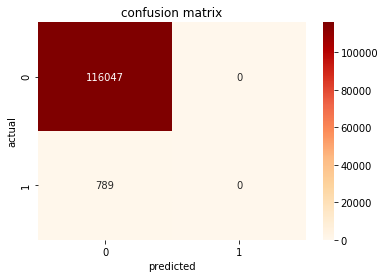

In [11]:
train_pred = tpot.predict(X_train)
print(classification_report(y_train,train_pred))
cm = confusion_matrix(y_train,train_pred)
plot_cm(cm)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     29034
         1.0       0.00      0.00      0.00       175

    accuracy                           0.99     29209
   macro avg       0.50      0.50      0.50     29209
weighted avg       0.99      0.99      0.99     29209



C:\Users\umaid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


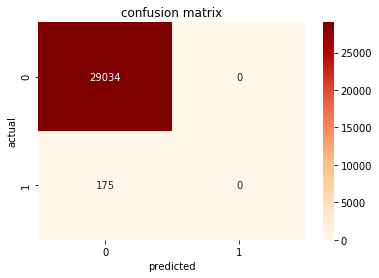

In [12]:
pred = tpot.predict(X_test)
cm = confusion_matrix(y_test,pred)
print(classification_report(y_test,pred))
plot_cm(cm)

#### Running with 50 generations

In [83]:
tpot = TPOTClassifier(generations=50, population_size=30, verbosity=2,n_jobs = -1,scoring = 'average_precision')

tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')

C:\Users\umaid\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\umaid\anaconda3\lib\site-packages\tpot\tpot.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _safe_indexing(target, unique_target_idx)
C:\Users\umaid\anaconda3\lib\site-packages\pandas\core\frame.py:2945: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer(key, value)
C:\Users\u


Generation 1 - Current best internal CV score: 0.1991185500638234
Generation 2 - Current best internal CV score: 0.1991185500638234
Generation 3 - Current best internal CV score: 0.1991185500638234
Generation 4 - Current best internal CV score: 0.2153860466016607
Generation 5 - Current best internal CV score: 0.2391069835668417
Generation 6 - Current best internal CV score: 0.2391069835668417
Generation 7 - Current best internal CV score: 0.2391069835668417
Generation 8 - Current best internal CV score: 0.2391069835668417
Generation 9 - Current best internal CV score: 0.2391069835668417
Generation 10 - Current best internal CV score: 0.2391069835668417
Generation 11 - Current best internal CV score: 0.2391069835668417
Generation 12 - Current best internal CV score: 0.2391069835668417
Generation 13 - Current best internal CV score: 0.24564336720938468
Generation 14 - Current best internal CV score: 0.2596254738262252
Generation 15 - Current best internal CV score: 0.2596254738262252
Ge

C:\Users\umaid\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.2701067370824614


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    116047
         1.0       1.00      0.93      0.97       789

    accuracy                           1.00    116836
   macro avg       1.00      0.97      0.98    116836
weighted avg       1.00      1.00      1.00    116836



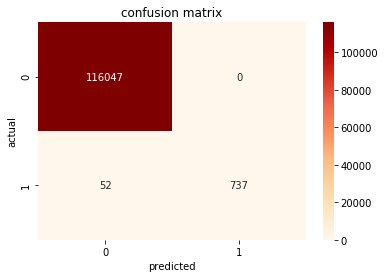

In [109]:
train_pred = tpot.predict(X_train)
print(classification_report(y_train,train_pred))
cm = confusion_matrix(y_train,train_pred)
plot_cm(cm)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     29034
         1.0       0.50      0.01      0.01       175

    accuracy                           0.99     29209
   macro avg       0.75      0.50      0.50     29209
weighted avg       0.99      0.99      0.99     29209



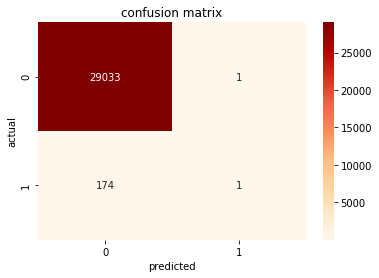

In [111]:
pred = tpot.predict(X_test)
cm = confusion_matrix(y_test,pred)
print(classification_report(y_test,pred))
plot_cm(cm)

## h2o

In [121]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.8+10-LTS, mixed mode)
  Starting server from C:\Users\umaid\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\umaid\AppData\Local\Temp\tmp5zvdsi3s
  JVM stdout: C:\Users\umaid\AppData\Local\Temp\tmp5zvdsi3s\h2o_umaid_started_from_python.out
  JVM stderr: C:\Users\umaid\AppData\Local\Temp\tmp5zvdsi3s\h2o_umaid_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Karachi
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_umaid_0phg25
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.971 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [380]:
h_df = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [381]:
factorslist = ['fraud']
h_df[factorslist] = h_df[factorslist].asfactor()

In [382]:
y = "fraud"
x = h_df.columns
x.remove(y)
x.remove('g_id')
x.remove('fyear')
x.remove('gvkey')

In [383]:
train,test = h_df.split_frame([0.8],seed = 42)

In [367]:
aml = H2OAutoML(max_models = 25, seed = 1,stopping_metric = "auc",balance_classes= True)
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |
21:46:53.347: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [368]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20201014_214653,0.815756,0.0348749,0.0610182,0.432264,0.0794874,0.00631825
StackedEnsemble_BestOfFamily_AutoML_20201014_214653,0.808939,0.0360654,0.0534716,0.450264,0.0799589,0.00639343
GBM_grid__1_AutoML_20201014_214653_model_2,0.802171,0.0487424,0.07197,0.440448,0.0805129,0.00648232
GBM_4_AutoML_20201014_214653,0.801906,0.0420687,0.0634523,0.438362,0.0802855,0.00644575
GBM_3_AutoML_20201014_214653,0.799961,0.0383882,0.0458056,0.456307,0.0801886,0.00643021
GBM_grid__1_AutoML_20201014_214653_model_8,0.799786,0.0389761,0.0480143,0.440655,0.0802469,0.00643956
XRT_1_AutoML_20201014_214653,0.79813,0.0381681,0.0487116,0.429767,0.080282,0.0064452
GBM_2_AutoML_20201014_214653,0.797034,0.0368472,0.0389355,0.432224,0.080124,0.00641985
GBM_grid__1_AutoML_20201014_214653_model_4,0.79544,0.0370633,0.0473579,0.444631,0.0801152,0.00641845
GBM_5_AutoML_20201014_214653,0.793633,0.052121,0.130175,0.410541,0.0803636,0.00645831


In [369]:
leader_model = aml.leader

In [371]:
leader_model.model_performance(train)


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.0011248841018450207
RMSE: 0.03353929191031052
LogLoss: 0.009270067538603072
Null degrees of freedom: 116904
Residual degrees of freedom: 116884
Null deviance: 9179.519420234168
Residual deviance: 2167.434491200784
AIC: 2209.434491200784
AUC: 0.999841269363565
AUCPR: 0.9763350090167293
Gini: 0.99968253872713

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25921680111569273: 


,,0,1,Error,Rate
0,0,116099.0,45.0,0.0004,(45.0/116144.0)
1,1,69.0,692.0,0.0907,(69.0/761.0)
2,Total,116168.0,737.0,0.001,(114.0/116905.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.259217,0.923899,167.0
1,max f2,0.162913,0.939762,193.0
2,max f0point5,0.318608,0.940762,154.0
3,max accuracy,0.259217,0.999025,167.0
4,max precision,0.999908,1.000000,0.0
5,max recall,0.060267,1.000000,246.0
6,max specificity,0.999908,1.000000,0.0
7,max absolute_mcc,0.259217,0.923528,167.0
8,max min_per_class_accuracy,0.074091,0.996608,235.0
9,max mean_per_class_accuracy,0.060267,0.997494,246.0



Gains/Lift Table: Avg response rate:  0.65 %, avg score:  1.14 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010008,0.072408,99.656205,99.656205,0.648718,0.546011,0.648718,0.546011,0.997372,0.997372,9865.620472,9865.620472,0.993833
1,2,0.020008,0.034412,0.262823,49.980761,0.001711,0.046878,0.325353,0.296551,0.002628,1.000000,-73.717667,4898.076101,0.986413
2,3,0.030007,0.024807,0.000000,33.325257,0.000000,0.028798,0.216933,0.207325,0.000000,1.000000,-100.000000,3232.525656,0.976348
3,4,0.040007,0.020213,0.000000,24.995724,0.000000,0.022337,0.162711,0.161088,0.000000,1.000000,-100.000000,2399.572375,0.966283
4,5,0.050006,0.017394,0.000000,19.997434,0.000000,0.018697,0.130174,0.132615,0.000000,1.000000,-100.000000,1899.743414,0.956218
5,6,0.100004,0.011099,0.000000,9.999572,0.000000,0.013671,0.065093,0.073148,0.000000,1.000000,-100.000000,899.957232,0.905893
6,7,0.150002,0.008529,0.000000,6.666572,0.000000,0.009677,0.043396,0.051993,0.000000,1.000000,-100.000000,566.657162,0.855567
7,8,0.200000,0.007075,0.000000,5.000000,0.000000,0.007750,0.032548,0.040932,0.000000,1.000000,-100.000000,400.000000,0.805242
8,9,0.300004,0.005482,0.000000,3.333286,0.000000,0.006178,0.021698,0.029347,0.000000,1.000000,-100.000000,233.328581,0.704582
9,10,0.400000,0.004608,0.000000,2.500000,0.000000,0.005007,0.016274,0.023263,0.000000,1.000000,-100.000000,150.000000,0.603931


In [370]:
leader_model.model_performance(test)


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.006726653273485089
RMSE: 0.08201617690117657
LogLoss: 0.03671277394606628
Null degrees of freedom: 29139
Residual degrees of freedom: 29119
Null deviance: 2421.966079798907
Residual deviance: 2139.6204655767424
AIC: 2181.6204655767424
AUC: 0.8041290992100897
AUCPR: 0.06658383481933482
Gini: 0.6082581984201794

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.029484668517640193: 


,,0,1,Error,Rate
0,0,28400.0,537.0,0.0186,(537.0/28937.0)
1,1,155.0,48.0,0.7635,(155.0/203.0)
2,Total,28555.0,585.0,0.0237,(692.0/29140.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.029485,0.121827,171.0
1,max f2,0.029485,0.171797,171.0
2,max f0point5,0.120659,0.155211,57.0
3,max accuracy,0.715239,0.993102,3.0
4,max precision,0.951165,1.000000,0.0
5,max recall,0.002868,1.000000,397.0
6,max specificity,0.951165,1.000000,0.0
7,max absolute_mcc,0.029485,0.129212,171.0
8,max min_per_class_accuracy,0.005835,0.724138,331.0
9,max mean_per_class_accuracy,0.007604,0.732827,307.0



Gains/Lift Table: Avg response rate:  0.70 %, avg score:  0.68 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010021,0.047292,13.273163,13.273163,0.092466,0.107489,0.092466,0.107489,0.133005,0.133005,1227.316283,1227.316283,0.123847
1,2,0.020007,0.029345,10.359047,11.818604,0.072165,0.036637,0.082333,0.072124,0.103448,0.236453,935.904728,1081.860430,0.217965
2,3,0.030027,0.023221,2.457993,8.694835,0.017123,0.026006,0.060571,0.056734,0.024631,0.261084,145.799312,769.483462,0.232677
3,4,0.040014,0.019439,5.919456,8.002180,0.041237,0.021211,0.055746,0.047868,0.059113,0.320197,491.945559,700.217999,0.282149
4,5,0.050000,0.016938,0.986576,6.600985,0.006873,0.018068,0.045985,0.041916,0.009852,0.330049,-1.342407,560.098522,0.282014
5,6,0.100000,0.011011,2.660099,4.630542,0.018531,0.013418,0.032258,0.027667,0.133005,0.463054,166.009852,363.054187,0.365601
6,7,0.150000,0.008555,2.266010,3.842365,0.015786,0.009682,0.026767,0.021672,0.113300,0.576355,126.600985,284.236453,0.429346
7,8,0.200000,0.007105,1.379310,3.226601,0.009609,0.007781,0.022478,0.018199,0.068966,0.645320,37.931034,222.660099,0.448444
8,9,0.300000,0.005508,1.034483,2.495895,0.007207,0.006215,0.017387,0.014205,0.103448,0.748768,3.448276,149.589491,0.451917
9,10,0.400000,0.004630,0.788177,2.068966,0.005491,0.005031,0.014413,0.011911,0.078818,0.827586,-21.182266,106.896552,0.430586


In [292]:
# leader_model.varimp_plot()

In [353]:
pred = leader_model.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [354]:
pd=h2o.as_list(pred) 
probs=pd["p1"].tolist()

In [355]:
pd=h2o.as_list(test) 
y_test=pd["fraud"].tolist()

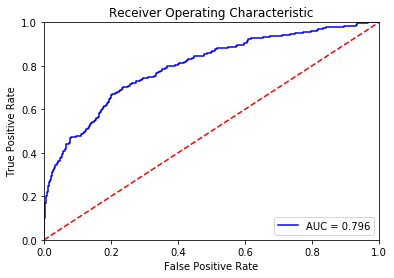

In [356]:
ROC(y_test,probs)

In [357]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_cm(cm):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(cm, annot=True,cmap="OrRd",fmt='g')
    plt.title('confusion matrix')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.show()

In [358]:
train_probs = leader_model.predict(train)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [359]:
pd=h2o.as_list(train_probs) 
probs=pd["p1"].tolist()
preds = np.where(np.array(probs) > 0.27529, 1, 0)
len(preds)

116905

In [360]:
train_df=h2o.as_list(train) 
true=train_df["fraud"].tolist()
len(true)

116905

In [361]:
cm = confusion_matrix(true,preds)

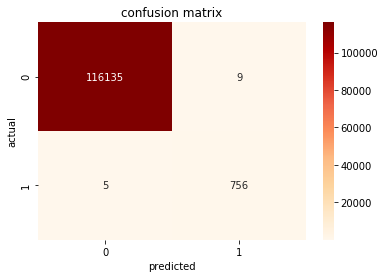

In [362]:
plot_cm(cm)

In [363]:
test_probs = leader_model.predict(test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [364]:
pd=h2o.as_list(test_probs) 
probs=pd["p1"].tolist()
preds = np.where(np.array(probs) > 0.27529, 1, 0)
len(preds)

29140

In [365]:
test_df=h2o.as_list(test) 
true=test_df["fraud"].tolist()
len(true)

29140

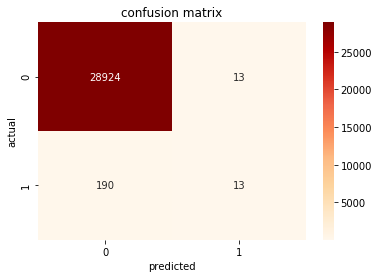

In [366]:
cm = confusion_matrix(true,preds)
plot_cm(cm)